In [1]:
from prophet import Prophet
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from multiprocessing import Pool, cpu_count
from pyspark.sql.types import *
from pyspark.sql.functions import pandas_udf, PandasUDFType
from tqdm import tqdm
from time import time 

C:\Users\yanco\.conda\envs\TensorFlow\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
ventas_raw = pd.read_csv("ventas_normalizadas.csv")
ventas_raw.shape

(213872, 8)

In [3]:
ventas_raw.head(5)

,fecha,producto_sk,unidades_vendidas,valor_vendido,categoria_sk,supercategoria,subcategoria,variedad
0,2020-07-01,35429,1.15,10.54,263,d703a0fa5b43ef3070c3007032401e5d,2e13624f1fb4828cd058e56c7ecc1ab5,Carne
1,2020-08-01,35429,5.57,49.70,263,d703a0fa5b43ef3070c3007032401e5d,2e13624f1fb4828cd058e56c7ecc1ab5,Carne
2,2020-09-01,35429,6.06,54.52,263,d703a0fa5b43ef3070c3007032401e5d,2e13624f1fb4828cd058e56c7ecc1ab5,Carne
3,2020-10-01,35429,6.30,56.76,263,d703a0fa5b43ef3070c3007032401e5d,2e13624f1fb4828cd058e56c7ecc1ab5,Carne
4,2020-11-01,35429,9.06,81.69,263,d703a0fa5b43ef3070c3007032401e5d,2e13624f1fb4828cd058e56c7ecc1ab5,Carne


In [4]:
ventas_categoria = ventas_raw.groupby(["fecha", "categoria_sk"]).sum().sort_values("valor_vendido", ascending=False)
ventas_categoria = ventas_categoria.reset_index()
ventas_categoria["ds"] = pd.to_datetime(ventas_categoria["fecha"])
ventas_categoria.drop(columns=["producto_sk", "fecha"], inplace=True)
ventas_categoria.shape

(2348, 4)

In [5]:
ventas_categoria.head(5)

,categoria_sk,unidades_vendidas,valor_vendido,ds
0,223,2010905.87,3037322.75,2021-12-01
1,223,1956607.05,2620055.29,2020-12-01
2,223,1735387.84,2523372.20,2021-05-01
3,223,1635669.40,2501271.13,2021-07-01
4,223,1554496.45,2417999.69,2021-08-01


<AxesSubplot:xlabel='ds', ylabel='unidades_vendidas'>

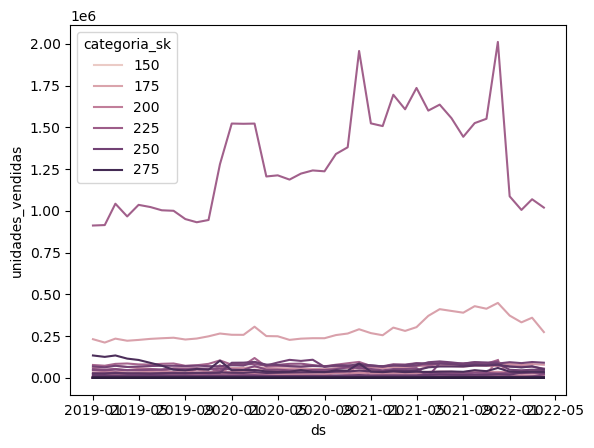

In [6]:
sns.lineplot(x=ventas_categoria.ds, y = ventas_categoria.unidades_vendidas, hue = ventas_categoria.categoria_sk)

In [7]:
ventas_categoria.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2348 entries, 0 to 2347
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   categoria_sk       2348 non-null   int64         
 1   unidades_vendidas  2348 non-null   float64       
 2   valor_vendido      2348 non-null   float64       
 3   ds                 2348 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 73.5 KB


In [8]:
groups_by_cat = ventas_categoria.groupby('categoria_sk')
groups_by_cat.groups.keys()

dict_keys([146, 151, 156, 162, 164, 169, 170, 176, 177, 182, 183, 184, 188, 192, 193, 194, 200, 203, 205, 207, 208, 209, 212, 214, 215, 216, 218, 219, 222, 223, 224, 229, 233, 234, 235, 236, 239, 241, 242, 245, 249, 252, 253, 254, 256, 258, 259, 263, 266, 267, 268, 270, 272, 275, 276, 278, 279, 283, 285, 288])

In [73]:
def train_and_forecast(group, tail=3, pred=6):

    # Initiate the model
    #m = Prophet(seasonality_mode='multiplicative', weekly_seasonality=False, daily_seasonality=False)
    m = Prophet()

    group.sort_values("ds").head(group.shape[0]-tail)
    
    # Fit the model
    m.fit(group)

    # Make predictions
    future = m.make_future_dataframe(periods=pred, freq="MS")
    forecast = m.predict(future)[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
    forecast['categoria_sk'] = group['categoria_sk'].iloc[0]

    # Return the forecasted results
    return forecast[['ds', 'categoria_sk', 'yhat', 'yhat_upper', 'yhat_lower']]  

In [49]:
ventas_categoria["valor_vendido_imputado"] = np.nan

In [50]:
medianas = ventas_categoria.groupby("categoria_sk").median()
medianas

,unidades_vendidas,valor_vendido,valor_vendido_imputado
categoria_sk,,,
146,97.720,366.360,NaN
151,5133.800,7031.315,NaN
156,346.450,1114.500,NaN
162,4395.475,17329.875,NaN
164,78.440,538.630,NaN
169,3807.040,4888.165,NaN
170,3312.500,38164.200,NaN
176,258010.275,528826.985,NaN
177,1285.355,4626.225,NaN


In [63]:
l = []
for row in ventas_categoria.iterrows():
    
    if row[1][2] < 100:
        l.append(medianas.loc[row[1][0]]["valor_vendido"])
    else:
        l.append(row[1][2]) 
        
        
    
ventas_categoria["valor_vendido_imputado"] = l
ventas_categoria

,categoria_sk,unidades_vendidas,valor_vendido,ds,valor_vendido_imputado
0,223,2010905.87,3037322.75,2021-12-01,3037322.750
1,223,1956607.05,2620055.29,2020-12-01,2620055.290
2,223,1735387.84,2523372.20,2021-05-01,2523372.200
3,223,1635669.40,2501271.13,2021-07-01,2501271.130
4,223,1554496.45,2417999.69,2021-08-01,2417999.690
...,...,...,...,...,...
2343,224,0.00,0.01,2021-02-01,4.220
2344,207,0.00,0.00,2021-03-01,706.105
2345,214,0.12,0.00,2021-06-01,3593.295
2346,266,0.00,0.00,2021-12-01,19.760


In [64]:
ventas_categoria[ventas_categoria["categoria_sk"]==146]

,categoria_sk,unidades_vendidas,valor_vendido,ds,valor_vendido_imputado
806,146,4398.66,15726.11,2022-01-01,15726.11
849,146,1817.12,12500.30,2021-10-01,12500.30
991,146,1002.69,6888.91,2021-12-01,6888.91
1049,146,640.73,5707.59,2020-10-01,5707.59
1105,146,1202.58,4996.94,2021-11-01,4996.94
1213,146,646.19,3717.01,2022-04-01,3717.01
1214,146,721.63,3711.67,2022-03-01,3711.67
1309,146,573.60,2830.05,2022-02-01,2830.05
1368,146,470.71,2305.06,2021-09-01,2305.06
1401,146,452.58,2027.90,2021-07-01,2027.90


In [74]:
# Start time
start_time = time()

# Create an empty dataframe
valor_forecast = pd.DataFrame()

# Loop through each ticker
for categoria in groups_by_cat.groups.keys():
    # Get the data for the ticker
    group = groups_by_cat.get_group(categoria)    
    # Make forecast
    forecast = train_and_forecast(group.rename(columns={"valor_vendido_imputado":"y"}))
    # Add the forecast results to the dataframe
    valor_forecast = pd.concat((valor_forecast, forecast))
    
print('The time used for the for-loop forecast is ', time()-start_time)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to overr

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to overr

The time used for the for-loop forecast is  180.90047335624695


In [10]:
# Start time
start_time = time()

# Create an empty dataframe
unidades_forecast = pd.DataFrame()

# Loop through each ticker
for categoria in groups_by_cat.groups.keys():
    # Get the data for the ticker
    group = groups_by_cat.get_group(categoria)    
    # Make forecast
    forecast = train_and_forecast(group.rename(columns={"unidades_vendidas":"y"}))
    # Add the forecast results to the dataframe
    unidades_forecast = pd.concat((unidades_forecast, forecast))
    
print('The time used for the for-loop forecast is ', time()-start_time)

The time used for the for-loop forecast is  145.88907623291016


In [69]:
ventas_categoria[ventas_categoria["categoria_sk"]==146].sort_values("ds")

,categoria_sk,unidades_vendidas,valor_vendido,ds,valor_vendido_imputado
2088,146,62.52,214.90,2019-01-01,214.90
2070,146,80.52,238.84,2019-02-01,238.84
2114,146,54.18,170.46,2019-03-01,170.46
2109,146,55.43,179.99,2019-04-01,179.99
2115,146,54.36,169.24,2019-05-01,169.24
2062,146,99.12,250.12,2019-06-01,250.12
2056,146,97.72,260.72,2019-07-01,260.72
2040,146,112.33,289.25,2019-08-01,289.25
2020,146,104.12,312.33,2019-09-01,312.33
1958,146,79.29,366.36,2019-10-01,366.36


In [82]:
valor_forecast[valor_forecast["categoria_sk"]==156].sort_values("ds")

,ds,categoria_sk,yhat,yhat_upper,yhat_lower
0,2019-01-01,156,1308.843887,1500.625705,1118.741180
1,2019-02-01,156,1462.626967,1639.637479,1272.445802
2,2019-03-01,156,1429.311754,1618.301721,1254.807289
3,2019-04-01,156,1348.687514,1536.260132,1164.169901
4,2019-05-01,156,1352.577907,1518.222629,1178.463477
5,2019-06-01,156,1323.404869,1507.239397,1138.935357
6,2019-07-01,156,1215.084885,1390.105493,1030.817179
7,2019-08-01,156,1188.991390,1363.877024,1024.341852
8,2019-09-01,156,911.319672,1095.824495,741.719076
9,2019-10-01,156,2044.458888,2234.551637,1851.118214


In [83]:
ventas_categoria[ventas_categoria["categoria_sk"]==156].sort_values("ds")

,categoria_sk,unidades_vendidas,valor_vendido,ds,valor_vendido_imputado
1550,156,409.04,1306.46,2019-01-01,1306.46
1569,156,406.47,1249.15,2019-02-01,1249.15
1527,156,455.18,1378.27,2019-03-01,1378.27
1532,156,440.01,1351.61,2019-04-01,1351.61
1530,156,442.81,1357.06,2019-05-01,1357.06
1526,156,448.56,1380.74,2019-06-01,1380.74
1533,156,451.02,1348.11,2019-07-01,1348.11
1561,156,408.01,1267.66,2019-08-01,1267.66
1607,156,363.15,1132.94,2019-09-01,1132.94
1367,156,824.98,2320.90,2019-10-01,2320.90
